In [1]:
import lib
import qutip as qt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
N = 3
J = 1

In [3]:
input = lib.generate_input_torch(N)

In [4]:
gamma_vals = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]

In [5]:
c = 1e-8
def reim(nn_output):
    return nn_output[:, 0] + 1.j * nn_output[:, 1] # Re, Im
def logamp_phase_c(nn_output):
    return (torch.exp(nn_output[:, 0]) - c) * torch.exp(1.j * nn_output[:, 1]) 
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])

In [6]:
true_z_abs = []
true_z_signed = []
true_x_abs = []
true_x_signed = []
z_abs = []
z_signed = []
x_abs = []
x_signed = []
for Gamma in gamma_vals:
    h = lib.TFIM_hamiltonian(N, J, Gamma)
    true_gs = h.eigenstates()[1][0]
    true_z_abs.append(lib.z_magnetization(N, true_gs, signed = False))
    true_z_signed.append(lib.z_magnetization(N, true_gs, signed = True))
    true_x_abs.append(lib.x_magnetization(N, true_gs, signed = False))
    true_x_signed.append(lib.x_magnetization(N, true_gs, signed = True))

    model = nn.Sequential(
        nn.Linear(N, 5 * N),
        nn.Sigmoid(),
        nn.Linear(5 * N, 2),
        nn.Sigmoid()
    )

    vars = (N, J, Gamma)
    loss_fn = lib.TFIM_expectation_from_torch
    epochs = []
    loss_data = []
    optimizer = torch.optim.SGD(model.parameters(), lr = 2)
    for epoch in range(1000):
        y_pred = model(input)
        loss = loss_fn(y_pred, vars, amp_phase)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            loss_data.append(loss.item())
            epochs.append(epoch)
    
    gs = lib.model_to_ground_state(model, input, amp_phase)
    gs = qt.Qobj(gs)
    z_abs.append(lib.z_magnetization(N, gs, signed = False))
    z_signed.append(lib.z_magnetization(N, gs, signed = True))
    x_abs.append(lib.x_magnetization(N, gs, signed = False))
    x_signed.append(lib.x_magnetization(N, gs, signed = True))


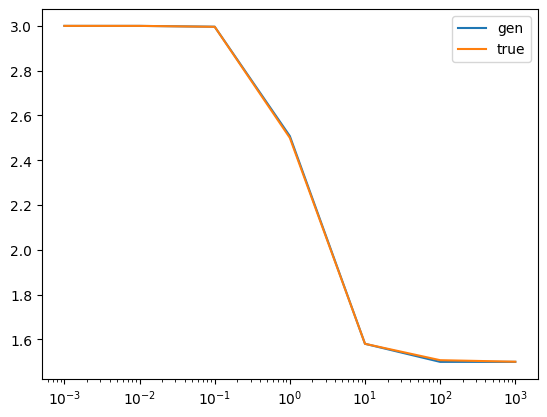

In [7]:
plt.plot(gamma_vals, z_abs, label='gen')
plt.plot(gamma_vals, true_z_abs, label='true')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

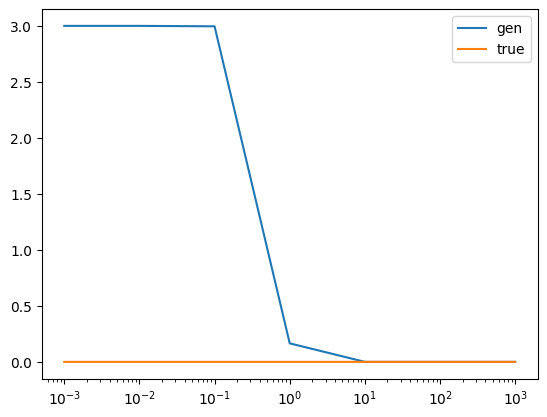

In [8]:
plt.plot(gamma_vals, z_signed, label='gen')
plt.plot(gamma_vals, true_z_signed, label='true')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

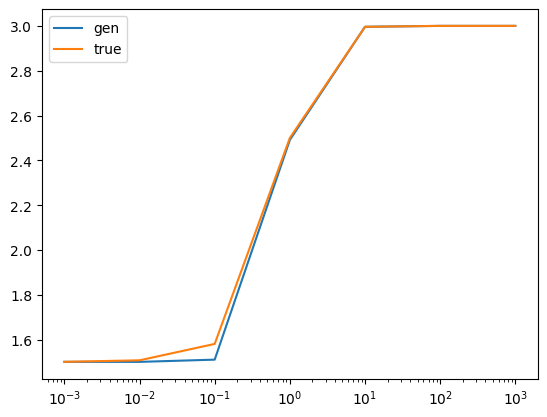

In [9]:
plt.plot(gamma_vals, x_abs, label='gen')
plt.plot(gamma_vals, true_x_abs, label='true')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

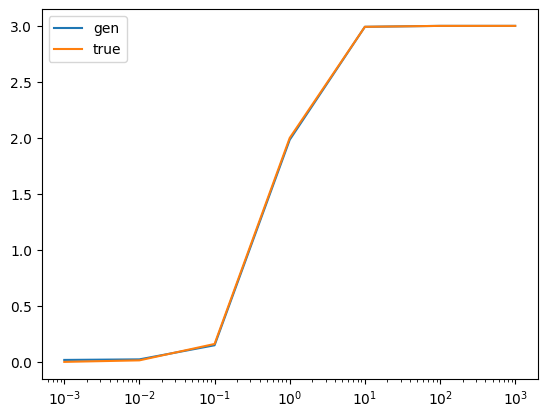

In [10]:
plt.plot(gamma_vals, x_signed, label='gen')
plt.plot(gamma_vals, true_x_signed, label='true')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [13]:
data = {'tza':{}, 'tzs':{}, 'txa':{}, 'txs':{}, 'za':{}, 'zs':{}, 'xa':{}, 'xs':{}}
ns = [n for n in range(2, 6)]
gamma_vals = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
for N in ns:
    for thing in data:
        data[thing][N] = []
    input = lib.generate_input_torch(N)
    for Gamma in gamma_vals:
        h = lib.TFIM_hamiltonian(N, J, Gamma)
        true_gs = h.eigenstates()[1][0]
        data['tza'][N].append(lib.z_magnetization(N, true_gs, signed = False))
        data['tzs'][N].append(lib.z_magnetization(N, true_gs, signed = True))
        data['txa'][N].append(lib.x_magnetization(N, true_gs, signed = False))
        data['txs'][N].append(lib.x_magnetization(N, true_gs, signed = True))

        model = nn.Sequential(
            nn.Linear(N, 5 * N),
            nn.Sigmoid(),
            nn.Linear(5 * N, 2),
            nn.Sigmoid()
        )

        vars = (N, J, Gamma)
        loss_fn = lib.TFIM_expectation_from_torch
        epochs = []
        loss_data = []
        optimizer = torch.optim.SGD(model.parameters(), lr = 2)
        for epoch in range(1000):
            y_pred = model(input)
            loss = loss_fn(y_pred, vars, amp_phase)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if epoch % 100 == 0:
                loss_data.append(loss.item())
                epochs.append(epoch)
        
        gs = lib.model_to_ground_state(model, input, amp_phase)
        gs = qt.Qobj(gs)
        data['za'][N].append(lib.z_magnetization(N, gs, signed = False))
        data['zs'][N].append(lib.z_magnetization(N, gs, signed = True))
        data['xa'][N].append(lib.x_magnetization(N, gs, signed = False))
        data['xs'][N].append(lib.x_magnetization(N, gs, signed = True))

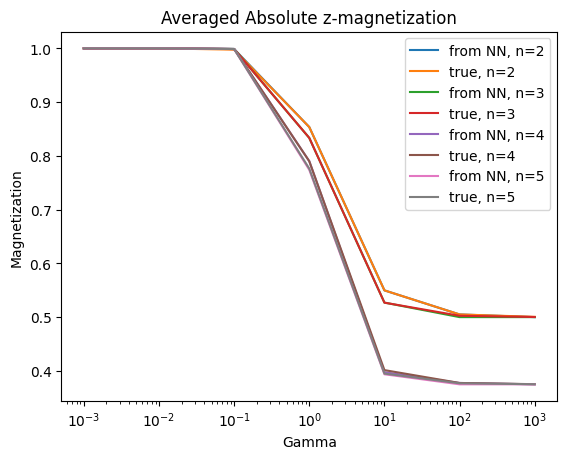

In [23]:
for N in ns:
    plt.plot(gamma_vals, np.array(data['za'][N]) / N, label=f'from NN, n={N}')
    plt.plot(gamma_vals, np.array(data['tza'][N]) / N, label=f'true, n={N}')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Averaged Absolute z-magnetization')
plt.ylabel('Magnetization')
plt.xlabel('Gamma')
plt.show()

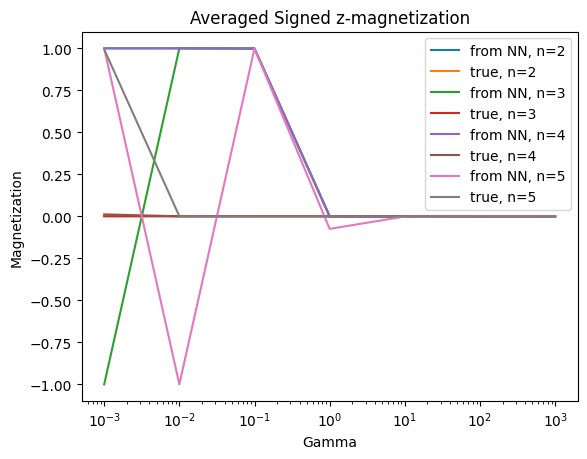

In [22]:
for N in ns:
    plt.plot(gamma_vals, np.array(data['zs'][N]) / N, label=f'from NN, n={N}')
    plt.plot(gamma_vals, np.array(data['tzs'][N]) / N, label=f'true, n={N}')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Averaged Signed z-magnetization')
plt.ylabel('Magnetization')
plt.xlabel('Gamma')
plt.show()

In [27]:
print(data['xa'][5])
print(data['txa'][5])


[array([1.87548339]), array([1.87532787]), array([1.89019103]), array([3.44278845]), array([4.98857093]), array([5.00000115]), array([5.00000067])]
[array([1.87496656]), array([1.87199309]), array([1.85638285]), array([3.43401699]), array([4.98747852]), array([4.999875]), array([4.99999875])]


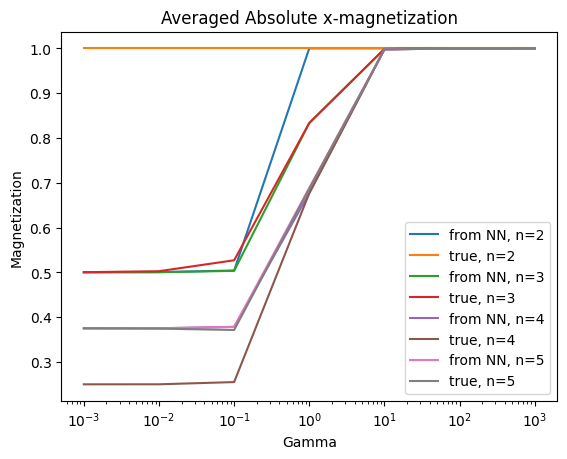

In [24]:
for N in ns:
    plt.plot(gamma_vals, np.array(data['xa'][N]) / N, label=f'from NN, n={N}')
    plt.plot(gamma_vals, np.array(data['txa'][N]) / N, label=f'true, n={N}')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Averaged Absolute x-magnetization')
plt.ylabel('Magnetization')
plt.xlabel('Gamma')
plt.show()

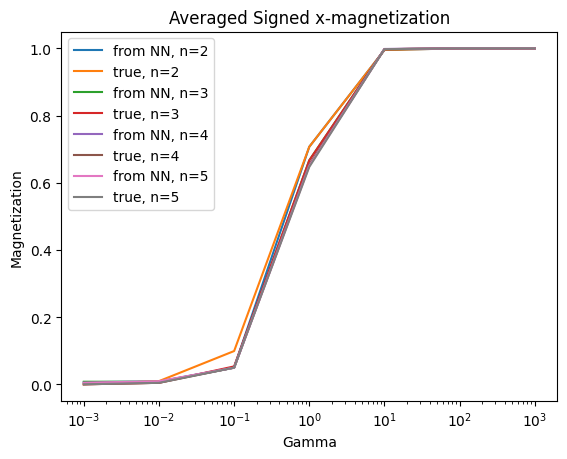

In [25]:
for N in ns:
    plt.plot(gamma_vals, np.array(data['xs'][N]) / N, label=f'from NN, n={N}')
    plt.plot(gamma_vals, np.array(data['txs'][N]) / N, label=f'true, n={N}')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Averaged Signed x-magnetization')
plt.ylabel('Magnetization')
plt.xlabel('Gamma')
plt.show()

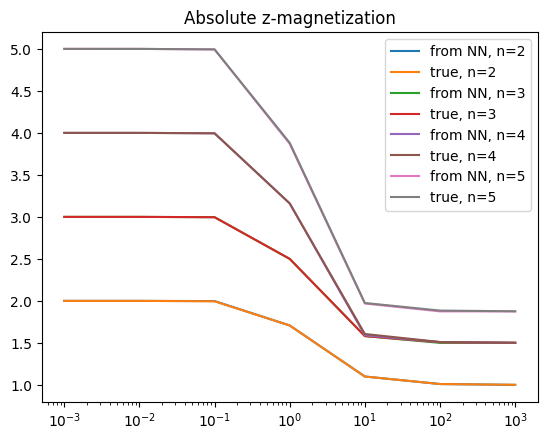

In [18]:
for N in ns:
    plt.plot(gamma_vals, data['za'][N], label=f'from NN, n={N}')
    plt.plot(gamma_vals, data['tza'][N], label=f'true, n={N}')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Absolute z-magnetization')
plt.show()

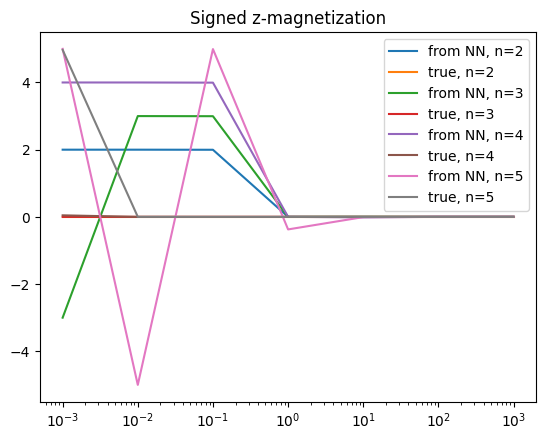

In [19]:
for N in ns:
    plt.plot(gamma_vals, data['zs'][N], label=f'from NN, n={N}')
    plt.plot(gamma_vals, data['tzs'][N], label=f'true, n={N}')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Signed z-magnetization')
plt.show()

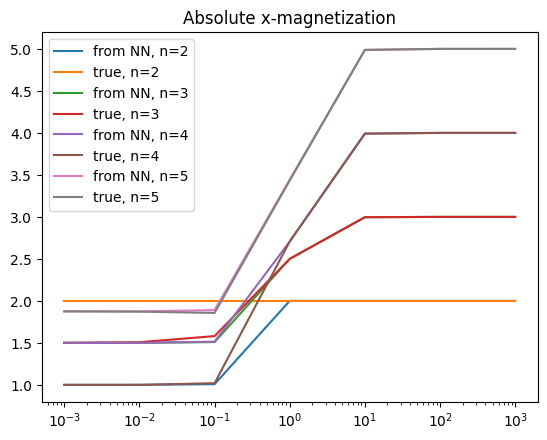

In [20]:
for N in ns:
    plt.plot(gamma_vals, data['xa'][N], label=f'from NN, n={N}')
    plt.plot(gamma_vals, data['txa'][N], label=f'true, n={N}')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Absolute x-magnetization')
plt.show()

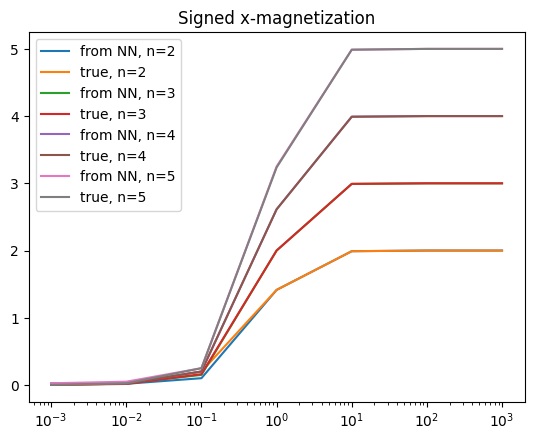

In [21]:
for N in ns:
    plt.plot(gamma_vals, data['xs'][N], label=f'from NN, n={N}')
    plt.plot(gamma_vals, data['txs'][N], label=f'true, n={N}')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Signed x-magnetization')
plt.show()